In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
%matplotlib notebook
from main import *

In [2]:
#Extracting the SS coverages previously saved and extracted from kMC files
ss_COVG_NONLAT = pd.read_csv('SS_Covg_nonLat.csv')
ss_COVG_LAT = pd.read_csv('SS_Covg_Lat.csv')

In [3]:
#Isolating pressures and ss coverages
Prs_non_lat = ss_COVG_NONLAT.iloc[:,0].to_numpy()
Prs_lat = ss_COVG_LAT.iloc[:,0].to_numpy()
ss_covg_non_lat = ss_COVG_NONLAT.iloc[:,1].to_numpy()
ss_covg_lat = ss_COVG_LAT.iloc[:,1].to_numpy()

In [4]:
#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [5]:
%%time
#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_NONLAT = []
Prs = Prs_non_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_NONLAT = np.append(MKM_SS_covg_NONLAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 3.22 s, sys: 42.3 ms, total: 3.27 s
Wall time: 3.71 s


In [6]:
%%time
#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_NONLAT = []
Prs = Prs_non_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_NONLAT = np.append(MKM_SS_covg_NONLAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 4.24 s, sys: 112 ms, total: 4.35 s
Wall time: 5.36 s


In [7]:
# selecting history to train from | lateral case
p_cnt = 0.5
train_ss_covg_lat = ss_covg_lat[:int(len(ss_covg_lat) * p_cnt)]
train_Prs_lat = Prs_lat[:int(len(Prs_lat) * p_cnt)]

_rest_Pred_Prs_lat = Prs_lat[int(len(Prs_lat) * p_cnt) :]

2023-09-19 22:09:57.972821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
10/10 - 1s - loss: 0.4855 - 984ms/epoch - 98ms/step
Epoch 2/10
10/10 - 0s - loss: 0.3318 - 24ms/epoch - 2ms/step
Epoch 3/10
10/10 - 0s - loss: 0.1932 - 20ms/epoch - 2ms/step
Epoch 4/10
10/10 - 0s - loss: 0.0924 - 20ms/epoch - 2ms/step
Epoch 5/10
10/10 - 0s - loss: 0.0295 - 25ms/epoch - 2ms/step
Epoch 6/10
10/10 - 0s - loss: 0.0056 - 19ms/epoch - 2ms/step
Epoch 7/10
10/10 - 0s - loss: 0.0033 - 25ms/epoch - 2ms/step
Epoch 8/10
10/10 - 0s - loss: 0.0038 - 22ms/epoch - 2ms/step
Epoch 9/10
10/10 - 0s - loss: 0.0030 - 20ms/epoch - 2ms/step
Epoch 10/10
10/10 - 0s - loss: 0.0026 - 23ms/epoch - 2ms/step
1/1 [==============================] - 0s 16ms/step


<IPython.core.display.Javascript object>


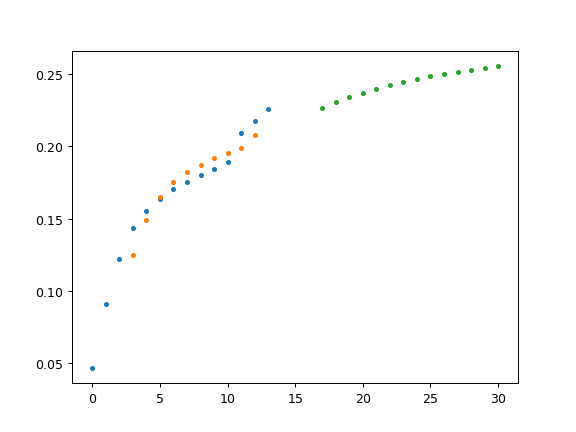

<IPython.core.display.Javascript object>


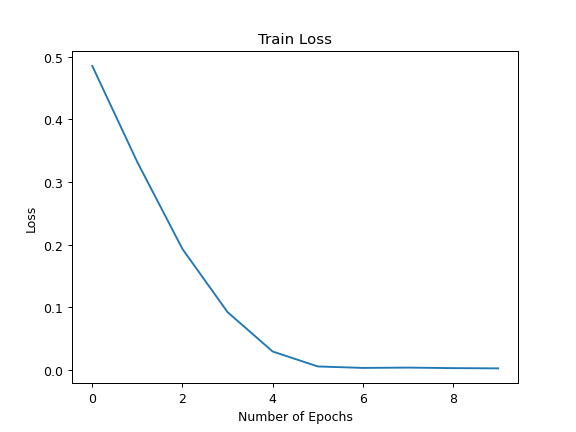

In [8]:
# LSTM for experiment O2 M0 with regression framing
import numpy as np
import os, random
import matplotlib.pyplot as plt
from pandas import read_csv
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

# convert an array of values into a dataset matrix
def create_dataset(inputdata, look_back):
    dataX, dataY = [], []
    for i in range(len(inputdata)-look_back-1):
        a = inputdata[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(inputdata[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# def reset_random_seeds():
#    os.environ['PYTHONHASHSEED']=str(2)
#    tf.random.set_seed(2)
#    np.random.seed(2)
#    random.seed(2)
   
# load the dataset
dataframe = pd.DataFrame(train_ss_covg_lat)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and predict size
# train_size = int(len(dataset) * 0.50) # *******
# predict_size = len(dataset) - train_size
#train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train = dataset

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
#testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# fix random seed for reproducibility
# reset_random_seeds()

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#result = model.fit(trainX, trainY, epochs=10, validation_data=(testX, testY), batch_size=1, verbose=2) # *******
result = model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2) # *******

# make train prediction
trainPredict = model.predict(trainX)
#testPredict = model.predict(testX)

# Predict future data
predictX = []
firstBatch = train[-look_back:]  # look_back = 4
currentBatch = firstBatch.reshape(1, 1, look_back)

futurePulses = len(_rest_Pred_Prs_lat) #200 # predict 500 future pulses M0
for j in range(futurePulses):
    pred = model.predict(currentBatch)
    predictX.append(pred)
    currentBatch = np.append(currentBatch[:, :, 1:],[pred], axis=2)

futurePredict_arr = np.array(predictX)
futurePredict = np.reshape(futurePredict_arr, (futurePredict_arr.shape[0], -1))

<IPython.core.display.Javascript object>


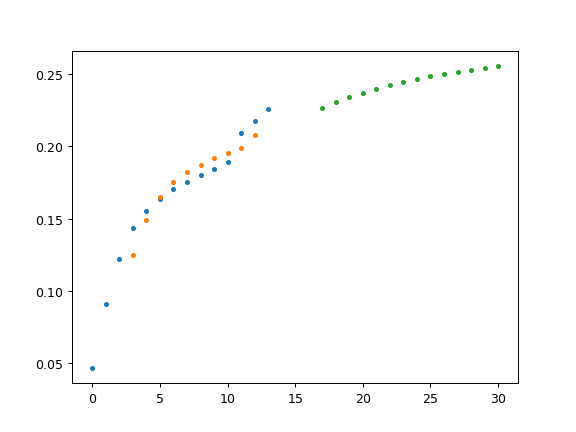

<IPython.core.display.Javascript object>


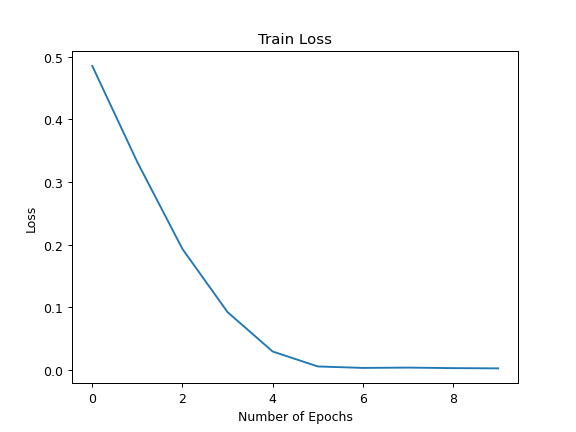

In [9]:

plt.figure()
plt.plot(scaler.inverse_transform(dataset), '.')
plt.plot(range(look_back,len(trainPredict)+look_back), scaler.inverse_transform(trainPredict), '.')
plt.plot(range(len(trainPredict)+(look_back*2)+1,len(dataset)+futurePulses+look_back),scaler.inverse_transform(futurePredict), '.')
plt.show()

plt.figure()
plt.plot(result.history['loss'])
#plt.plot(result.history['val_loss'])
plt.title('Train Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
# plt.legend(['Train']) #, 'Validation'])
plt.show()

<IPython.core.display.Javascript object>


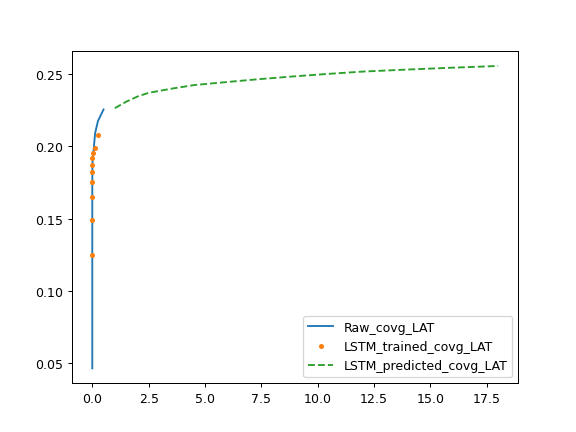

In [18]:
Trained_Prs = train_Prs_lat[look_back:-1]
trained_covg_lat = scaler.inverse_transform(trainPredict)
pred_lat = scaler.inverse_transform(futurePredict)
plt.figure()
# plt.plot(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.plot(train_Prs_lat, train_ss_covg_lat, label='Raw_covg_LAT')
plt.plot(Trained_Prs,trained_covg_lat, '.', label='LSTM_trained_covg_LAT')
plt.plot(_rest_Pred_Prs_lat,pred_lat, '--', label='LSTM_predicted_covg_LAT')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


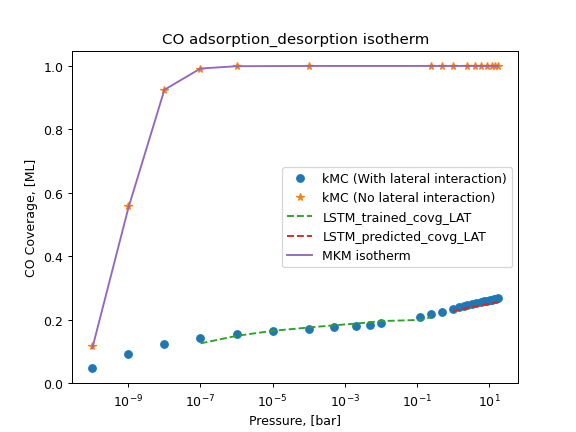

In [23]:
plt.figure()
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Trained_Prs,trained_covg_lat, '--', label='LSTM_trained_covg_LAT')
plt.semilogx(_rest_Pred_Prs_lat,pred_lat, '--', label='LSTM_predicted_covg_LAT')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs_lat,MKM_SS_covg_LAT,'--',label='MKM_LAT_Fitted isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

<IPython.core.display.Javascript object>


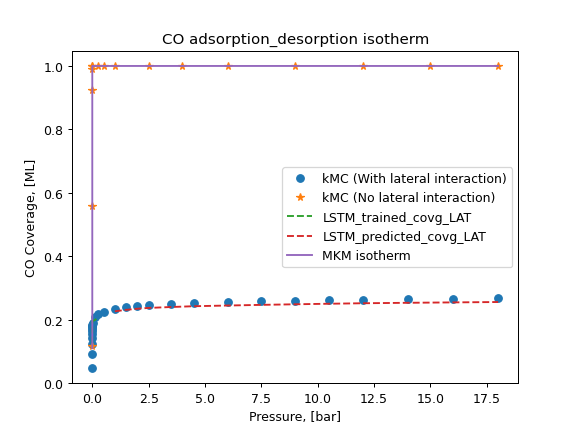

In [24]:
plt.figure()
plt.plot(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.plot(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.plot(Trained_Prs,trained_covg_lat, '--', label='LSTM_trained_covg_LAT')
plt.plot(_rest_Pred_Prs_lat,pred_lat, '--', label='LSTM_predicted_covg_LAT')
plt.plot(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs_lat,MKM_SS_covg_LAT,'--',label='MKM_LAT_Fitted isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()